## Import

In [ ]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
# 구글 드라이브 경로 설정 
DATA_PATH = '/content/gdrive/My Drive/LG Aimers phase3/' 
MODEL_PATH='/content/gdrive/My Drive/LG Aimers phase3/'
SUBMISSION_PATH='/content/gdrive/My Drive/LG Aimers phase3/' 

In [ ]:
import pandas as pd
import random
import os
import numpy as np
import sklearn.metrics as metrics
import statistics
import math as math
import seaborn as sns

from sklearn.ensemble import VotingClassifier
from lightgbm import plot_importance
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37) # Seed 고정

## Data Load

In [ ]:
train_df = pd.read_csv(DATA_PATH + 'train.csv')
test_df = pd.read_csv(DATA_PATH + 'test.csv')

# EDA

In [ ]:
# 칼럼 드랍
train_x = train_df.drop(columns=['PRODUCT_ID', 'Y_Class', 'Y_Quality'])
train_y = train_df['Y_Class']
test_x = test_df.drop(columns=['PRODUCT_ID'])

In [ ]:
# train 데이터 확인 (rows 1132, columns 3328, 많은 결측치 존재)
print(train_x)

         LINE PRODUCT_CODE  X_1    X_2  X_3   X_4   X_5  X_6   X_7   X_8  ...  \
0     T100304         T_31  2.0   95.0  0.0  45.0  10.0  0.0  45.0  10.0  ...   
1     T100306         T_31  2.0   96.0  0.0  45.0  10.0  0.0  53.0  10.0  ...   
2     T100306         T_31  2.0   95.0  0.0  45.0  10.0  0.0  60.0  10.0  ...   
3     T100306         T_31  2.0   87.0  0.0  45.0  10.0  0.0  53.0  10.0  ...   
4     T100306         T_31  2.0   95.0  0.0  45.0  10.0  0.0  51.0  10.0  ...   
...       ...          ...  ...    ...  ...   ...   ...  ...   ...   ...  ...   
1127  T050304         A_31  NaN    NaN  NaN   NaN   NaN  NaN   NaN   NaN  ...   
1128  T100304         T_31  2.0  102.0  0.0  45.0  11.0  0.0  45.0  10.0  ...   
1129  T100306         T_31  1.0   88.0  0.0  45.0  10.0  0.0  51.0  10.0  ...   
1130  T010306         A_31  NaN    NaN  NaN   NaN   NaN  NaN   NaN   NaN  ...   
1131  T100304         T_31  2.0  101.0  0.0  45.0  11.0  0.0  45.0  10.0  ...   

        X_3317    X_3318   

<Axes: xlabel='Y_Class', ylabel='count'>

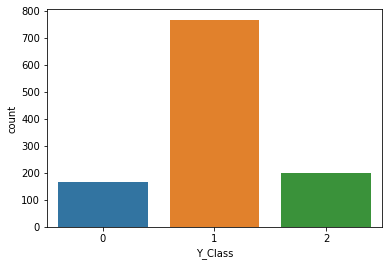

In [ ]:
# Y_Class 분포 확인, class_imbalance => over_sampling 시도해보았으나 성능향상 x
sns.countplot(data=train_df, x='Y_Class')

#Data preprocessing

In [ ]:
# 레이블인코딩
qual_col = ['LINE','PRODUCT_CODE']

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train_x[i])
    train_x[i] = le.transform(train_x[i])
    
    for label in np.unique(test_x[i]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)
    test_x[i] = le.transform(test_x[i])
print('Done.')

Done.


In [ ]:
# 결측치 처리
train_x = train_x.fillna(0)
test_x = test_x.fillna(0)

In [ ]:
# 결측치 확인
print(train_x.isna().any())
print(test_x.isna().any())

LINE            False
PRODUCT_CODE    False
X_1             False
X_2             False
X_3             False
                ...  
X_3322          False
X_3323          False
X_3324          False
X_3325          False
X_3326          False
Length: 3328, dtype: bool
LINE            False
PRODUCT_CODE    False
X_1             False
X_2             False
X_3             False
                ...  
X_3322          False
X_3323          False
X_3324          False
X_3325          False
X_3326          False
Length: 3328, dtype: bool


# Data Split

In [ ]:
from sklearn.model_selection import train_test_split

# train-test분리
X_train, X_test, y_train, y_test = train_test_split(train_x ,train_y, test_size=0.2)

# train-validation분리
X2_train, X_val, y2_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# XGBClassifier, LGBMClassifier HyperParameter Tuning & Test

In [ ]:
XGB = XGBClassifier(n_estimators=100, learning_rate=0.08, gamma = 0, subsample=0.75, colsample_bytree = 1, max_depth=7, alpha=4, n_jobs=-1
                   , booster='gbtree', importance_type='gain', min_child_weight=5
                   )
LGBM = LGBMClassifier(n_estimators=100, learning_rate=0.08, subsample=0.75, colsample_bytree = 1, max_depth=7, alpha=4, n_jobs=-1
                   , importance_type='gain', min_child_weight=5
                   )

XGB.fit(X_train, y_train)
preds = XGB.predict(X_test)

print("훈련 세트 정확도: {:.3f}".format(XGB.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(XGB.score(X_test, y_test)))
print("현재 Macro F1 Score의 검증 점수: {:.3f}".format(f1_score(preds, y_test, average = "macro")))
print("\n")  

XGB.fit(X2_train, y2_train)
preds2 = XGB.predict(X_val)

print("검증훈련 세트 정확도: {:.3f}".format(XGB.score(X2_train, y2_train)))
print("검증테스트 세트 정확도: {:.3f}".format(XGB.score(X_val, y_val)))
print("현재 Macro F1 Score의 검증 점수: {:.3f}".format(f1_score(preds2, y_val, average = "macro")))
print("\n") 

LGBM.fit(X_train, y_train)
preds = LGBM.predict(X_test) 

print("훈련 세트 정확도: {:.3f}".format(LGBM.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(LGBM.score(X_test, y_test)))
print("현재 Macro F1 Score의 검증 점수: {:.3f}".format(f1_score(preds, y_test, average = "macro")))
print("\n") 

LGBM.fit(X2_train, y2_train)
preds2 = LGBM.predict(X_val)

print("검증훈련 세트 정확도: {:.3f}".format(LGBM.score(X2_train, y2_train)))
print("검증테스트 세트 정확도: {:.3f}".format(LGBM.score(X_val, y_val)))
print("현재 Macro F1 Score의 검증 점수: {:.3f}".format(f1_score(preds2, y_val, average = "macro"))) 

훈련 세트 정확도: 0.937
테스트 세트 정확도: 0.722
현재 Macro F1 Score의 검증 점수: 0.560


검증훈련 세트 정확도: 0.934
검증테스트 세트 정확도: 0.718
현재 Macro F1 Score의 검증 점수: 0.579


훈련 세트 정확도: 0.997
테스트 세트 정확도: 0.780
현재 Macro F1 Score의 검증 점수: 0.666


검증훈련 세트 정확도: 1.000
검증테스트 세트 정확도: 0.713
현재 Macro F1 Score의 검증 점수: 0.570


#Voting Classifier Model

In [ ]:
VM = VotingClassifier(
    estimators=[('XGB',XGB),('LGBM',LGBM)], 
    voting='hard', n_jobs=-1
    )

## Submit

In [ ]:
VM.fit(train_x, train_y)
preds = VM.predict(test_x)

In [ ]:
submit = pd.read_csv(DATA_PATH + './sample_submission.csv')

In [ ]:
submit['Y_Class'] = preds

In [ ]:
submit.to_csv(DATA_PATH + './code.csv', index=False)